### Recommendation system - Foodpanda case study:

Foodpanda front end (www.foodpanda.sg) is displaying by restaurant level. Each of restaurant has unique primary cuisine and multiple secondary cuisines. The platform wants to create a recommendation lane to customers top 3 cuisines they are likelihood to choose but have never ordered before. 

Question: 
1. Please advise at least one model for recommending top 3 cuisines which customers are likelihood to choose but have never ordered before. Briefly describe how this recommendation model works
2. Giving below is a dataset of 100 customers with orders from different cuisines. Please use Python/Excel or any application to execuse your recommended model above to give results.
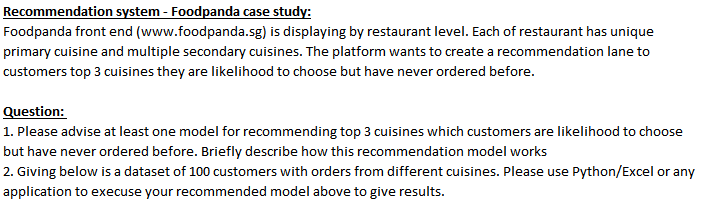

In this notebook, we attempt to use foodpanda order history of a 100 users to create a recommendation system. The approach attempted is User-based Collaborative Filtering (read more: https://www.geeksforgeeks.org/user-based-collaborative-filtering/). Essentially we are attempting to find other users that are identical/similar to any given user to understand the user's preference.

### Import libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity

In [2]:
df = pd.read_csv('fp_recommend.csv')

### Exploratory Data Analysis

In [3]:
# Import all necessary dataset 
df.head()

,cuisine,Numbers of order,Customer_id
0,Fast Food,10,1
1,Cakes & Bakery,2,1
2,Western,1,1
3,Non-alcoholic Drinks,1,1
4,Chinese,4,1


In [4]:
# Count number of unique customers
len(df['Customer_id'].unique())

100

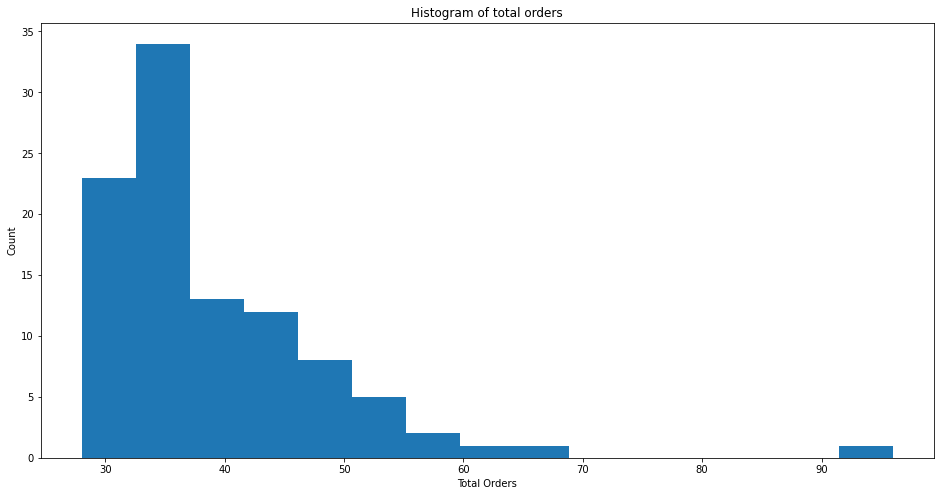

In [5]:
# Plot histogram of total orders a customer make
plt.figure(figsize=(16,8))
plt.hist(df.groupby('Customer_id')['Numbers of order'].sum(), bins = 15)
plt.xlabel('Total Orders')
plt.ylabel('Count')
plt.title('Histogram of total orders')
plt.show()

In this dataset most customers made a total of 30 - 50 orders. The distribution has a long right tail, with some customers making more than 90 orders.

This information is useful as all customers made a substantial amount of orders for us to infer their preferences.

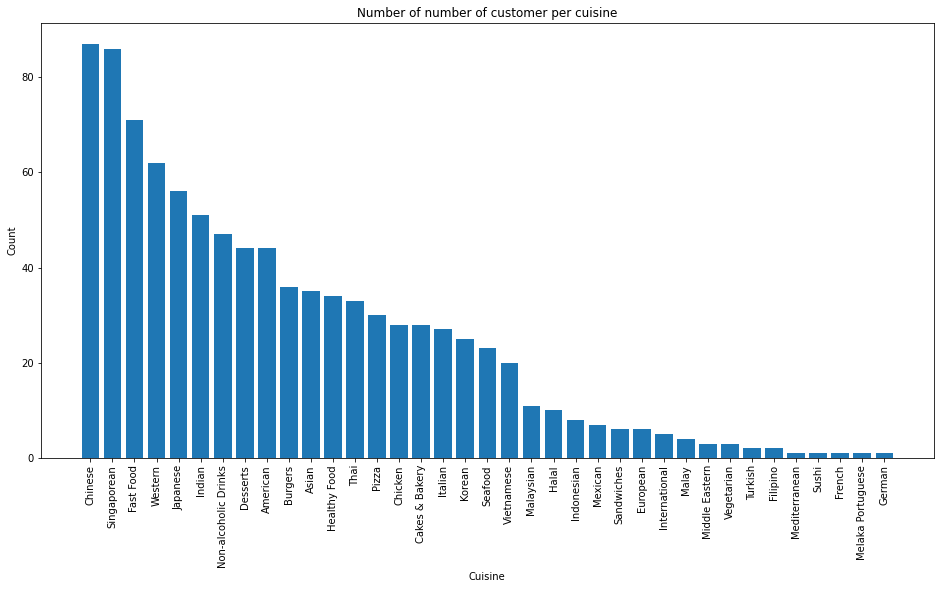

In [6]:
# Plot barchart of number of customer per cuisine
plt.figure(figsize=(16,8))
plt.bar(df['cuisine'].value_counts().index, df['cuisine'].value_counts())
plt.xticks(rotation = '90')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.title('Number of number of customer per cuisine')
plt.show()

Not all cuisines are commonly ordered. Some like Chinese, Singaporean, Fast Food are ordered by most customers. Others like Mediterranean, German and French are ordered by very few customers.

In this recommendation system, we use number of order as a signal of preference of the customer. We will be assuming that if a customer orders a cuisine many times, they prefer that cuisine. Conversely, if a customer orders a cuisine very infrequently, they do not prefer that cuisine. If a customer has never ordered a cuisine before, they are not exposed to the cuisine. We will have to use a recommendation system to find individuals with similar preferences to infer the customer's preferences.

### Modelling

The approach taken to create a recommendation system is User-based Collaborative Filtering:

1) We first create a utility matrix which seeks to list out all users and the cuisines they have purchased.

2) With the utility matrix, we identify similar/disimilar users by measuring their cosine similarity.

3) We use the cosine similarity with other users as weights to explore the user's preference for cuisines that they have not tried.

#### Utility matrix

In [7]:
# Create pivot table
pivot = pd.pivot_table(df, index = 'cuisine', columns = 'Customer_id', values='Numbers of order')

In [8]:
# Preview table
pivot.head()

Customer_id,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
cuisine,,,,,,,,,,,,,,,,,,,,,
American,2.0,6.0,1.0,2.0,4.0,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,2.0,NaN,NaN,2.0,1.0,NaN,NaN,NaN
Asian,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,3.0,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN
Burgers,NaN,6.0,5.0,NaN,NaN,NaN,NaN,3.0,6.0,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,2.0,1.0
Cakes & Bakery,2.0,NaN,2.0,1.0,NaN,1.0,NaN,1.0,2.0,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Chicken,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,9.0,2.0,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,2.0


In [9]:
# Initiate standard scaler
ss = StandardScaler()
# Standardize the data
pivot_ss =  pd.DataFrame(ss.fit_transform(pivot), index = pivot.index, columns = pivot.columns)

In [10]:
# Create sprase matrix
sparse_pivot = sparse.csr_matrix(pivot_ss.fillna(0))

#### Similarity matrix

In [11]:
# Get cosine similarity
sim_matrix = cosine_similarity(sparse_pivot.T)
sim_matrix = pd.DataFrame(sim_matrix, columns = pivot.columns, index = pivot.columns)

In [12]:
# Preview cosine similarity matrix
sim_matrix.head()

Customer_id,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
Customer_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.159196,0.228667,0.433125,-0.357230,0.386836,0.345600,0.233085,0.267538,0.423591,...,0.235005,0.120727,0.559670,-0.029935,0.260073,0.041877,-0.041788,-0.123930,0.213418,0.087517
2,0.159196,1.000000,0.346219,0.678624,-0.052532,0.764631,0.748598,0.627904,0.569540,0.626773,...,0.733794,0.604994,-0.102659,0.337610,0.515376,0.339019,0.062205,0.337787,0.154654,0.341106
3,0.228667,0.346219,1.000000,0.367690,-0.053094,0.322706,0.636897,0.655879,0.115779,0.254972,...,0.282637,0.563436,0.069239,-0.269135,0.421966,0.692771,-0.005100,0.401512,0.411087,0.513381
4,0.433125,0.678624,0.367690,1.000000,-0.234219,0.834988,0.663992,0.511206,0.630583,0.777506,...,0.635165,0.516696,0.106488,0.151920,0.361864,0.234536,0.004294,0.078579,0.061428,0.195850
5,-0.357230,-0.052532,-0.053094,-0.234219,1.000000,-0.057586,-0.198034,-0.156081,-0.145918,-0.183788,...,0.126831,-0.125916,-0.183877,0.000507,0.106587,0.130189,0.133382,-0.019523,-0.094969,-0.009669


#### Check similiarity matrix

In [13]:
# Preview similarity matrix
sim_matrix[1].sort_values(ascending = False)

Customer_id
1     1.000000
34    0.870303
84    0.734655
39    0.694904
20    0.682484
        ...   
72   -0.195592
59   -0.219105
17   -0.220836
90   -0.280440
5    -0.357230
Name: 1, Length: 100, dtype: float64

We see that Customer 1 is similar to customer 34, 84, 39

In [14]:
pivot[[1,34,84,39]]

Customer_id,1,34,84,39
cuisine,,,,
American,2.0,NaN,NaN,NaN
Asian,NaN,1.0,1.0,NaN
Burgers,NaN,NaN,1.0,NaN
Cakes & Bakery,2.0,1.0,1.0,NaN
Chicken,NaN,NaN,NaN,NaN
Chinese,4.0,5.0,NaN,NaN
Desserts,1.0,1.0,1.0,NaN
European,NaN,NaN,NaN,NaN
Fast Food,10.0,9.0,18.0,17.0


Quick observations show that these 4 users have strong preference towards FastFood

#### Get weights and multiply with other users consumption pattern

In [15]:
# Create a function to 
def get_recommendations(cust):
    # Get similarity matrix and weights associated with other customers
    sim = sim_matrix[cust].drop(cust)
    # Remove negative similarity
    sim = sim[sim > 0]
    # Get series of weights
    weights = sim.values/np.sum(sim.values)
    
    # Get vector of customer null values (Cuisines with NA)
    preference = pivot[pivot[cust].isnull()].drop(cust, axis = 1)
    preference = preference[sim.index]
    
    # Get scores of user preference
    cust_pref = np.dot(preference.fillna(0).values, weights)
    results = pd.DataFrame(cust_pref, index = preference.index)
    
    # Return top 3 cuisine recommendation
    return results.sort_values(ascending = False, by = 0)[:3]

In [16]:
# Test function
get_recommendations(1)

,0
cuisine,
Japanese,1.353082
Asian,1.347961
Burgers,0.788722


#### Create recommendations

In [17]:
# Create new dataframe
final = pd.DataFrame(range(1,101), columns = ['customer_id'])

In [18]:
# Create 3 features
final['rec_1'] = final['customer_id'].apply(lambda x: get_recommendations(x).index[0])
final['rec_2'] = final['customer_id'].apply(lambda x: get_recommendations(x).index[1])
final['rec_3'] = final['customer_id'].apply(lambda x: get_recommendations(x).index[2])

In [19]:
final.set_index('customer_id', inplace = True)

In [20]:
# Preview recommemdation
final.head()

,rec_1,rec_2,rec_3
customer_id,,,
1,Japanese,Asian,Burgers
2,Indian,Non-alcoholic Drinks,Asian
3,Fast Food,Asian,Non-alcoholic Drinks
4,Indian,Japanese,Asian
5,Japanese,Healthy Food,Sandwiches


In [21]:
# Create .csv
final.to_csv('recommendation.csv')

### Conclusion

In this notebook, we attempted to create a user-based collaborative filtering recommendation system. The results looks sensible, however we are unable to evaluate the efficacy of the recommendation. This notebook serves as an exploration as a practice notebook to create such a recommendation system.